#### EE6310: Image and Video Processing

#### Assignment 6

#### Tanmay Goyal- AI20BTECH11021

In [212]:
import numpy as np
import matplotlib.pyplot as plt

In [213]:
# importing the images
frame1 = plt.imread('first_frame.png')
print(frame1.shape)

(144, 176)


In [214]:
# importing the images
frame2 = plt.imread('second_frame.png')
print(frame2.shape)

(144, 176)


#### **1. Motion Estimation**

1. Use the 3-step search to find motion vectors:
    
    Divide each frame into non-overlapping 16x16 macroblocks.
    <ul>
    <li> Use Mean Absolute Distance (MAD)

    <li> Step 1: Search at 8 locations ± 4 pixels around current macroblock including (0,0)

    <li> Step 2: Search around 8 locations ±2 pixels around best match location in step 1 including best match location

    <li> Step 3: Search around 8 locations ±1 pixels around best match location in step 2 including best match location
    
    </ul>

2. Plot the motion vector at each macroblock. 

3. Generate the motion compensated predicted frame using the motion vectors and the first frame. 

4. Compute the error between the predicted frame and the first frame and display it.

In [215]:
def three_step_search(frame1 , frame2):
    '''
    Performs a three step search to estimate the motion vectors.

    Parameters
        frame1 : First frame of the video sequence.
        frame2 : Second frame of the video sequence.

    Returns        
            motion_vectors : A list of motion vectors for each block in the frame.
    '''

    if frame1.shape != frame2.shape:
        print("The two frames must be of the same size.")
        return

    try:
        M , N = frame1.shape
    except:
        frame1 = frame1[:,:,:-1].mean(2)
        frame2 = frame2[:,:,:-1].mean(2)
        M , N = frame1.shape

    # will hold the starting and ending point of each motion vector
    motion_vectors = []

    for j in range(0 , N , 16):
        for i in range(0 , M , 16):
            
            # extracting 16x16 block
            block = frame1[i : i+16 , j : j+16]

            center_point = (i+8 , j+8)
            
            best_point1 = search_around(block , frame2 , center_point , 4)
            best_point2 = search_around(block , frame2 , best_point1 , 2)
            best_point3 = search_around(block , frame2 , best_point2 , 1)

            motion_vectors.append((center_point , best_point3))

    return motion_vectors


In [216]:
def search_around(block , frame , center_point , step_size):
    '''
    Performs a search around the center point to find the point with minimum MAD

    Parameters
        block : The block from the first frame.
        frame : The second frame.
        center_point : The center point around which the search is performed.
        step_size : The step size of the search.

    Returns
        best_point : The point with minimum MAD.
    '''

    best_point = center_point

    # initializing the minimum MAD to a large value to mimic infinity
    min_MAD = 1e10

    for i in range(center_point[0]-step_size , center_point[0]+step_size+1 , step_size):
        for j in range(center_point[1]-step_size , center_point[1]+step_size+1 , step_size):

            try:
                # extracting the 16x16 block from the second frame
                block2 = frame[i-8 : i+8 , j-8 : j+8]

                # we normalize the score because in some cases we might not have 16x16 blocks
                MAD_score = MAD(block , block2) / (16*16)   
                best_point = (i , j) if MAD_score < min_MAD else best_point
                min_MAD = MAD_score if MAD_score < min_MAD else min_MAD

            except: 

                # 16x16 block does not exist around that point
                left_distance = min(j , 8)
                right_distance = min(frame.shape[1] - j  ,8)
                top_distance = min(i , 8)
                bottom_distance = min(frame.shape[0] - i , 8)

                # we extract the block from the frame
                block2 = frame[i-top_distance : i+bottom_distance , j-left_distance : j+right_distance]

                # we also reduce the block to required shape
                block1 = block[8-top_distance : 8+bottom_distance , 8-left_distance : 8+right_distance]

                # we normalize the score because in some cases we might not have 16x16 blocks   
                MAD_score = MAD(block1 , block2) / (block1.shape[0]*block1.shape[1])
                best_point = (i , j) if MAD_score < min_MAD else best_point
                min_MAD = MAD_score if MAD_score < min_MAD else min_MAD

    return best_point

In [217]:
def MAD(block1  , block2):
    '''
    Calculates the Mean Absolute Difference between two blocks.

    Parameters
        block1 : First block.
        block2 : Second block.

    Returns
        MAD_score : The MAD score.
    '''

    return np.sum(np.abs(block1 - block2))

In [218]:
def plot_vector_field(frame1 , motion_vector_field):
    '''
    This function plots the motion vector field on the given frame

    Parameters:
        frame1 : first frame
        motion_vector_field : a list containing tuples of the motion vectors

    Returns:
        None
    '''

    plt.imshow(frame1 , cmap = 'gray')
    for i in range(len(motion_vector_field)):
        plt.arrow(motion_vector_field[i][0][1] , motion_vector_field[i][0][0] , 
                  motion_vector_field[i][1][1] - motion_vector_field[i][0][1] , 
                  motion_vector_field[i][1][0] - motion_vector_field[i][0][0] , 
                  head_width = 2 , head_length = 1.5 , color = 'r')
    plt.title("Estimated motion vectors")

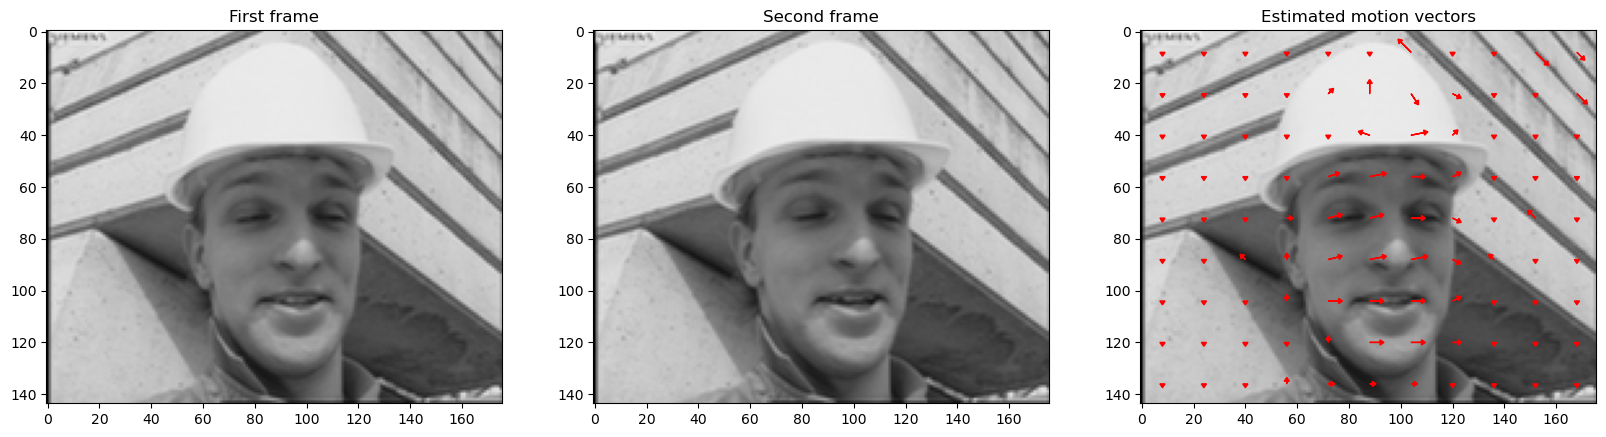

In [219]:
plt.figure(figsize = (20 , 20))

plt.subplot(1 , 3 , 1)
plt.imshow(frame1 , cmap = 'gray')
plt.title("First frame")

plt.subplot(1 , 3 , 2)
plt.imshow(frame2 , cmap = 'gray')
plt.title("Second frame")

plt.subplot(1 , 3 , 3)
m = three_step_search(frame1 , frame2)
plot_vector_field(frame1 , m)

plt.show()

In [220]:
def predict_frame(frame1 , motion_vector_field):
    '''
    This function predicts the second frame using motion vectors

    Parameters:
        frame1 : first frame
        motion_vector_field : a list containing tuples of the motion vectors

    Returns:
        predicted_frame : predicted frame
    ''' 

    try:
        M , N = frame1.shape
    except:
        frame1 = frame1[:,:,:-1].mean(2)
        M , N = frame1.shape

    # finding maximum vector length
    vec_l = -1000

    for vector in motion_vector_field:
        p1 , p2 = vector
        vec_l = max(vec_l , np.int64(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)))
    
    predicted_frame = np.zeros((M + 2*vec_l , N + 2*vec_l))

    for vector in motion_vector_field:

        original_center , predicted_center = vector

        original_block = frame1[original_center[0] - 8 : original_center[0] + 8 ,\
                original_center[1] - 8 : original_center[1] + 8]

        new_center = (predicted_center[0] + vec_l , predicted_center[1] + vec_l)
        predicted_frame[new_center[0] - 8 : new_center[0] + 8 ,\
                new_center[1] - 8 : new_center[1] + 8] = original_block

    return predicted_frame[vec_l:-vec_l , vec_l:-vec_l]
    

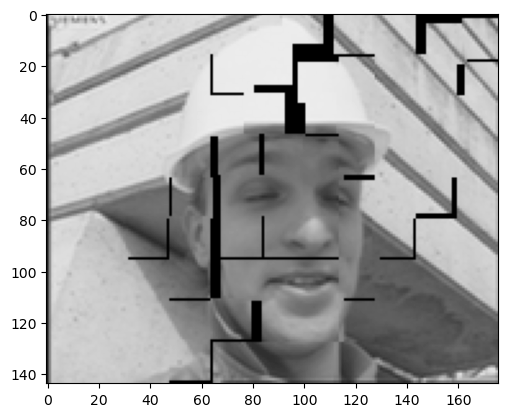

In [221]:
f_pred = predict_frame(frame1 , m)
plt.imshow(f_pred , cmap = 'gray')

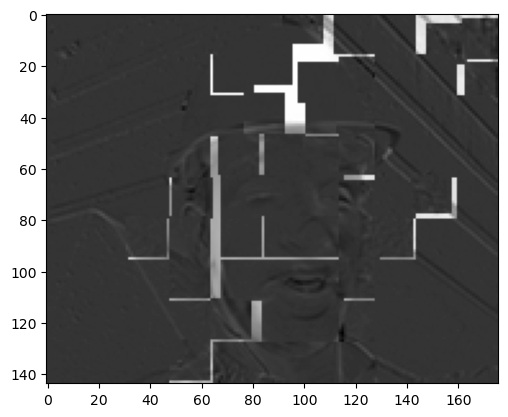

In [223]:
plt.imshow((frame2 - f_pred) , cmap = 'gray')